In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym

In [2]:
env = gym.make('FrozenLake-v0', is_slippery=True)

In [3]:
print("Action space = ", env.action_space)
print("Observation space = ", env.observation_space)

Action space =  Discrete(4)
Observation space =  Discrete(16)


In [4]:
actionsDict = {}
actionsDict[0] = "  L  "
actionsDict[1] = "  D  "
actionsDict[2] = "  R  "
actionsDict[3] = "  U  "

actionsDictInv = {}
actionsDictInv["L"] = 0
actionsDictInv["D"] = 1
actionsDictInv["R"] = 2
actionsDictInv["U"] = 3

In [5]:
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [6]:
optimalPolicy = ["L/D/R","  U  ","  U  ","  U  ",
                 "  L  ","  -  "," L/R ","  -  ",
                 "  U  ","  D  ","  L  ","  -  ",
                 "  -  ","  R  ","  D  ","  !  "]
    
print("Optimal policy:")
idxs = [0,4,8,12]
for idx in idxs:
    print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
          optimalPolicy[idx+2], optimalPolicy[idx+3])

Optimal policy:
L/D/R   U     U     U  
  L     -    L/R    -  
  U     D     L     -  
  -     R     D     !  


In [7]:
def action_epsilon_greedy(q, s, epsilon=0.05):
    if np.random.rand() > epsilon:
        return np.argmax(q[s])
    return np.random.randint(4)

def get_action_epsilon_greedy(epsilon):
    return lambda q,s: action_epsilon_greedy(q, s, epsilon=epsilon)

In [8]:
def greedy_policy(q, s):
    return np.argmax(q[s])

In [9]:
def average_performance(policy_fct, q):
    acc_returns = 0.
    n = 100
    for i in range(n):
        done = False
        s = env.reset()
        while not done:
            a = policy_fct(q, s)
            s, reward, done, info = env.step(a)
            acc_returns += reward
    return acc_returns/n

In [10]:
nb_episodes = 80000
STEPS = 2000
epsilon_param = [[0.2, 0.001, int(nb_episodes/2)]]

In [11]:
# SARSA: On-policy TD control algorithm
def sarsa(alpha = 0.02, 
          gamma = 1., 
          epsilon_start = 0.1,
          epsilon_end = 0.001,
          epsilon_annealing_stop = int(nb_episodes/2),
          q = None, 
          progress = None, 
          env=env):
    
    if q is None:
        q = np.ones((16,4))
        # Set q(terminal,*) equal to 0
        q[5,:] = 0.0
        q[7,:] = 0.0
        q[11,:] = 0.0
        q[12,:] = 0.0
        q[15,:] = 0.0
    
    for i in range(nb_episodes):
        
        inew = min(i,epsilon_annealing_stop)
        epsilon = (epsilon_start * (epsilon_annealing_stop - inew) + epsilon_end * inew) / epsilon_annealing_stop
        
        done = False
        s = env.reset()
        a = action_epsilon_greedy(q, s, epsilon=epsilon)
        while not done:
            new_s, reward, done, info = env.step(a)
            new_a = action_epsilon_greedy(q, new_s, epsilon=epsilon)
            q[s, a] = q[s, a] + alpha * (reward + gamma * q[new_s, new_a] - q[s, a])
            s = new_s
            a = new_a
        
        # only for plotting the performance, not part of the algorithm 
        if progress is not None and i%STEPS == 0:
            progress[i//STEPS] = average_performance(get_action_epsilon_greedy(epsilon), q=q)
    return q, progress

In [12]:
sarsa_performance = np.ndarray(nb_episodes//STEPS)
q, sarsa_performance = sarsa(alpha = 0.02, gamma = 1, progress=sarsa_performance, 
                             epsilon_start=epsilon_param[0][0], epsilon_end=epsilon_param[0][1], 
                             epsilon_annealing_stop = epsilon_param[0][2])

Text(0, 0.5, 'Average reward of an epoch')

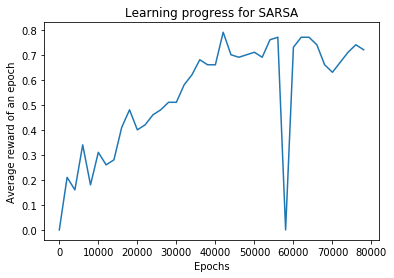

In [13]:
plt.plot(STEPS*np.arange(nb_episodes//STEPS), sarsa_performance)
plt.xlabel("Epochs")
plt.title("Learning progress for SARSA")
plt.ylabel("Average reward of an epoch")

In [14]:
greedyPolicyAvgPerf = average_performance(greedy_policy, q=q)
print("Greedy policy SARSA performance =", greedyPolicyAvgPerf) 

Greedy policy SARSA performance = 0.75


In [15]:
q = np.round(q,3)
print("(A,S) Value function =", q.shape)
print("First row")
print(q[0:4,:])
print("Second row")
print(q[4:8,:])
print("Third row")
print(q[8:12,:])
print("Fourth row")
print(q[12:16,:])

(A,S) Value function = (16, 4)
First row
[[0.829 0.781 0.785 0.785]
 [0.416 0.394 0.347 0.816]
 [0.522 0.521 0.511 0.813]
 [0.376 0.327 0.378 0.811]]
Second row
[[0.83  0.552 0.568 0.549]
 [0.    0.    0.    0.   ]
 [0.32  0.195 0.535 0.142]
 [0.    0.    0.    0.   ]]
Third row
[[0.55  0.59  0.546 0.831]
 [0.557 0.83  0.441 0.506]
 [0.776 0.56  0.397 0.342]
 [0.    0.    0.    0.   ]]
Fourth row
[[0.    0.    0.    0.   ]
 [0.528 0.619 0.886 0.506]
 [0.814 0.943 0.877 0.844]
 [0.    0.    0.    0.   ]]


In [16]:
policyFound = [actionsDict[np.argmax(q[0,:])],actionsDict[np.argmax(q[1,:])],actionsDict[np.argmax(q[2,:])],actionsDict[np.argmax(q[3,:])],
               actionsDict[np.argmax(q[4,:])],"  -  ",actionsDict[np.argmax(q[6,:])],"  -  ",
               actionsDict[np.argmax(q[8,:])],actionsDict[np.argmax(q[9,:])],actionsDict[np.argmax(q[10,:])],"  -  ",
               "  -  ",actionsDict[np.argmax(q[13,:])],actionsDict[np.argmax(q[14,:])],"  !  "]
print("Greedy policy found:")
idxs = [0,4,8,12]
for idx in idxs:
    print(policyFound[idx+0], policyFound[idx+1], 
          policyFound[idx+2], policyFound[idx+3])

print(" ")

print("Optimal policy:")
idxs = [0,4,8,12]
for idx in idxs:
    print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
          optimalPolicy[idx+2], optimalPolicy[idx+3])

Greedy policy found:
  L     U     U     U  
  L     -     R     -  
  U     D     L     -  
  -     R     D     !  
 
Optimal policy:
L/D/R   U     U     U  
  L     -    L/R    -  
  U     D     L     -  
  -     R     D     !  
